# CARGUE DE LOS DATOS Y TRANSFORMACIONES

In [ ]:
#pip install sodapy

In [ ]:
#pip install xgboost

In [ ]:
#pip install matplotlib

In [ ]:
#pip install seaborn

In [ ]:
#!pip install scikit-learn


In [32]:
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2, mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Socrata('www.datos.gov.co', None)
tempTr = client.get("8yi9-t44c", limit=200000)
datos = pd.DataFrame.from_records(tempTr) 
datos.head()

,idpeaje,peaje,categoriatarifa,desde,hasta,valortarifa,cantidadtrafico,cantidadevasores,cantidadexentos787
0,1,ALVARADO,I,2015-08-21T00:00:00.000,2015-08-31T00:00:00.000,7000,27730,0,660
1,1,ALVARADO,II,2015-08-21T00:00:00.000,2015-08-31T00:00:00.000,7600,9930,0,70
2,1,ALVARADO,III,2015-08-21T00:00:00.000,2015-08-31T00:00:00.000,16100,1277,0,0
3,1,ALVARADO,IV,2015-08-21T00:00:00.000,2015-08-31T00:00:00.000,20400,2074,0,0
4,1,ALVARADO,V,2015-08-21T00:00:00.000,2015-08-31T00:00:00.000,22900,4167,0,0


# LIMPIEZA Y ALISTAMIENTO

In [20]:
datos.desde = pd.to_datetime(datos.desde)
datos.hasta = pd.to_datetime(datos.hasta)
datos.valortarifa = datos.valortarifa.astype('int')
datos.cantidadtrafico = datos.cantidadtrafico.astype('int')
datos.cantidadevasores = datos.cantidadevasores.apply(pd.to_numeric, errors='coerce')
datos.cantidadexentos787 = datos.cantidadexentos787.apply(pd.to_numeric, errors='coerce')
datos['año'] = pd.DatetimeIndex(datos['hasta']).year
datos['mes'] = pd.DatetimeIndex(datos['hasta']).month
datos['añomes'] = pd.to_datetime(datos.hasta).dt.to_period('M')
datos['recaudo'] = datos.valortarifa * datos.cantidadtrafico
datos.idpeaje = datos.idpeaje.astype('int')

datos.head()

,idpeaje,peaje,categoriatarifa,desde,hasta,valortarifa,cantidadtrafico,cantidadevasores,cantidadexentos787,año,mes,añomes,recaudo
0,1,ALVARADO,17,2015-08-21,2015-08-31,7000,27730,0.0,660.0,2015,8,2015-08,194110000
1,1,ALVARADO,25,2015-08-21,2015-08-31,7600,9930,0.0,70.0,2015,8,2015-08,75468000
2,1,ALVARADO,29,2015-08-21,2015-08-31,16100,1277,0.0,0.0,2015,8,2015-08,20559700
3,1,ALVARADO,31,2015-08-21,2015-08-31,20400,2074,0.0,0.0,2015,8,2015-08,42309600
4,1,ALVARADO,36,2015-08-21,2015-08-31,22900,4167,0.0,0.0,2015,8,2015-08,95424300


In [4]:
cat = LabelEncoder().fit(datos.categoriatarifa)
datos.categoriatarifa = cat.fit_transform(datos.categoriatarifa)

In [5]:
datos.cantidadevasores.fillna(0,inplace=True)
datos.cantidadexentos787.fillna(0,inplace=True)

In [6]:
pd.isna(datos).sum()

idpeaje               0
peaje                 0
categoriatarifa       0
desde                 0
hasta                 0
valortarifa           0
cantidadtrafico       0
cantidadevasores      0
cantidadexentos787    0
año                   0
mes                   0
añomes                0
recaudo               0
dtype: int64

In [7]:
columnasX = ['idpeaje','categoriatarifa','año','mes','valortarifa','cantidadevasores','cantidadexentos787']
columnasY = ['cantidadtrafico']

In [24]:
datosT = datos[columnasX+columnasY].groupby(by=['idpeaje', 'categoriatarifa', 'valortarifa', 'año', 'mes'], as_index=False).sum()

In [25]:
Xtrain, Xtest, ytrain, ytest = train_test_split(datosT[columnasX], datosT[columnasY], test_size=0.30, random_state=8)

# REVISIÓN OPCIONES DE MODELOS

In [33]:
def calculo_rmse(ypred,yTest,ypredTr,yTrain):
    RMSE = round(mse(ypred, yTest, squared = False))
    MSE = round(mse(ypred, yTest))
    MAE = round(mae(ypred, yTest))
    R2 = r2(ypred,yTest)

    RMSE_Tr = round(mse(ypredTr, yTrain, squared = False))
    MSE_Tr = round(mse(ypredTr, yTrain))
    MAE_Tr = round(mae(ypredTr, yTrain))
    R2_Tr = r2(ypredTr,yTrain)

    # Cálculo del desempeño del modelo utilizando el RMSE y el MAE
    print(f'El RMSE del modelo es de {RMSE}')
    print(f'El MSE del modelo es de {MSE}')
    print(f'El MAE del modelo es de {MAE}')
    print(f'El MAE del modelo es de {R2}')

    print(f'El RMSE del modelo en train es de {RMSE_Tr}')
    print(f'El MSE del modelo en train es de {MSE_Tr}')
    print(f'El MAE del modelo en train es de {MAE_Tr}')
    print(f'El r2 del modelo en train es de {R2_Tr}')

## Random Forest

El parámetro max_depth que mejor calibra el modelo es 38


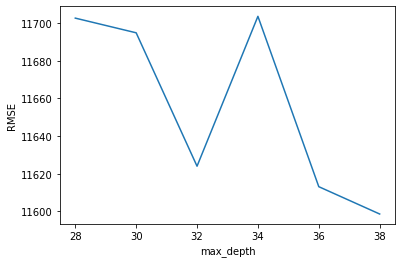

In [10]:
np.random.seed(123)

# Creación de lista de valores para iterar sobre diferentes valores de max_depth
max_depth_range = range(28, 40 ,2)

# Definición de lista para almacenar el rmse promedio para cada valor de max_depth
rmse_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for max_depth in max_depth_range:
    reg = RandomForestRegressor(max_depth = max_depth, n_jobs=-1)
    scores = cross_val_score(reg, Xtrain, ytrain, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)
    rmse_scores.append(np.mean(np.sqrt(np.abs(scores))))

# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(max_depth_range, rmse_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
best_max_depth = max_depth_range[rmse_scores.index(min(rmse_scores))]
print(f'El parámetro max_depth que mejor calibra el modelo es {best_max_depth}')

El parámetro max_features que mejor calibra el modelo es 5


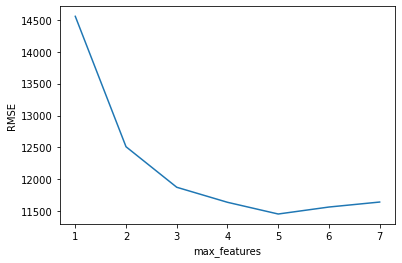

In [11]:
np.random.seed(123)

# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, Xtrain.shape[1] + 1)

# Definición de lista para almacenar el rmse promedio para cada valor de max_features
rmse_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    reg = RandomForestRegressor(max_depth = best_max_depth, max_features = feature, n_jobs=-1)
    scores = cross_val_score(reg, Xtrain, ytrain, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)
    rmse_scores.append(np.mean(np.sqrt(np.abs(scores))))

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, rmse_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE')
best_max_feau = rmse_scores.index(min(rmse_scores)) + 1
print(f'El parámetro max_features que mejor calibra el modelo es {best_max_feau}')

El parámetro n_estimators que mejor calibra el modelo es 300


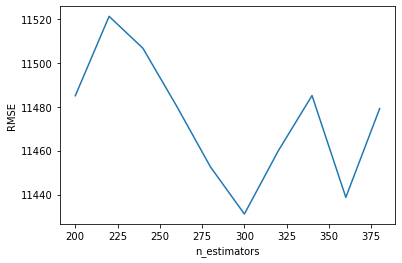

In [12]:
np.random.seed(123)

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(200, 400, 20)

# Definición de lista para almacenar el rmse promedio para cada valor de n_estimators
rmse_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    reg = RandomForestRegressor(max_depth = best_max_depth, max_features = best_max_feau, n_estimators = estimator, n_jobs=-1)
    scores = cross_val_score(reg, Xtrain, ytrain, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)
    rmse_scores.append(np.mean(np.sqrt(np.abs(scores))))

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
best_estimator_range = estimator_range[rmse_scores.index(min(rmse_scores))]
print(f'El parámetro n_estimators que mejor calibra el modelo es {best_estimator_range}')

In [13]:
np.random.seed(123)

# Implementación y ajuste del modelo de regresión de Random Forest calibrado con los datos de entrenamiento
rfcreg = RandomForestRegressor(max_depth = best_max_depth, max_features = best_max_feau, n_estimators = best_estimator_range).fit(Xtrain, ytrain)

# Predicción con los datos de prueba
ypred = rfcreg.predict(Xtest)

RMSE_RFC = round(mean_squared_error(ypred, ytest, squared = False))
MAE_RFC = round(mean_absolute_error(ypred, ytest))
r2 = r2_score(ytest, ypred)
# Cálculo del desempeño del modelo utilizando el RMSE y el MAE
print(f'El RMSE del modelo es de {RMSE_RFC}')
print(f'El MAE del modelo es de {MAE_RFC}')
print(f'El R^2 del modelo es de {r2}')

El RMSE del modelo es de 10048
El MAE del modelo es de 2790
El R^2 del modelo es de 0.9657380473257273


## K vecinos

In [14]:
# parámetros
parametros_grid = {
    'n_neighbors': [3, 5, 7],  # Puedes ajustar estos valores según tus necesidades
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
# Inicializa el modelo de KNeighborsRegressor
regKN = KNeighborsRegressor()

# Se utiliza GridSearchCV para encontrar los mejores parámetros
grid_regKN = GridSearchCV(regKN, parametros_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_regKN.fit(Xtrain, ytrain)

# Obtiene el mejor modelo con los mejores parámetros
mejor_regKN = grid_regKN.best_estimator_

# Predicciones con el modelo ajustado
predRegKN = mejor_regKN.predict(Xtest)

# Muestra los mejores parámetros encontrados
print(f"Mejores parámetros: {grid_regKN.best_params_}")

# Métricas 
RMSE_regKN = round(mean_squared_error(predRegKN, ytest, squared=False))
r2_regKN = r2_score(ytest, predRegKN)
print(f'El RMSE del modelo es de {RMSE_regKN}')
print(f'El R^2 del modelo es de {r2_regKN}')

Mejores parámetros: {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'distance'}
El RMSE del modelo es de 21325
El R^2 del modelo es de 0.8456778097629603


In [15]:
regKN = KNeighborsRegressor(n_neighbors=7,weights='distance',algorithm='brute')
regKN.fit(Xtrain,ytrain)
predRegKN = regKN.predict(Xtest)
predRegKN

array([[92154.56521739],
       [65918.80683934],
       [ 1700.43046148],
       ...,
       [ 6676.16495016],
       [ 4429.86580041],
       [ 2898.57526938]])

## XGBoost

In [27]:
#n_estimators=1000, scale_pos_weight=1, reg_alpha= 0.005
param_test = {
    'learning_rate':[0.01,0.05,0.1,0.15],
    'gamma':[i/10.0 for i in range(0,5)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'max_depth':[6,8,10],
    'min_child_weight':[4,5,6],
    'subsample':[i/10.0 for i in range(6,10)]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor(n_jobs=-1,seed=123), 
param_grid = param_test, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=3, verbose=True)
gsearch2.fit(Xtrain,ytrain)
gsearch2.best_params_

Fitting 3 folds for each of 2880 candidates, totalling 8640 fits


{'colsample_bytree': 0.8,
 'gamma': 0.0,
 'learning_rate': 0.15,
 'max_depth': 10,
 'min_child_weight': 4,
 'subsample': 0.9}

In [28]:
gsearch2.best_score_

-10696.454155121775

In [29]:
#n_estimators=1000, scale_pos_weight=1, reg_alpha= 0.005
param_test = {
    'n_estimators':[i for i in range(100,750,50)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate = 0.15, max_depth=10, min_child_weight=4,gamma=0,
                                                 subsample=0.9, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, 
                                                 reg_alpha= 0.005,seed=123),
                        param_grid = param_test, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=3, verbose=True)
gsearch3.fit(Xtrain,ytrain)
gsearch3.best_params_

Fitting 3 folds for each of 13 candidates, totalling 39 fits


{'n_estimators': 650}

In [30]:
gsearch3.best_score_

-10107.683447644902

# MODELOS ESCOGIDOS

In [34]:
# Implementación y ajuste del modelo de regresión de Random Forest calibrado con los datos de entrenamiento
regXGB4 = XGBRegressor(learning_rate = 0.15, n_estimators=650, max_depth=10, min_child_weight=4, 
                       gamma=0, subsample=0.9, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, 
                       reg_alpha= 0.01,seed=123).fit(Xtrain, ytrain)
ypredTrXGB4 = regXGB4.predict(Xtrain)
ypredXGB4 = regXGB4.predict(Xtest)

calculo_rmse(ypredXGB4,ytest,ypredTrXGB4,ytrain)

El RMSE del modelo es de 8967
El MSE del modelo es de 80405705
El MAE del modelo es de 2795
El MAE del modelo es de 0.9732949966782461
El RMSE del modelo en train es de 1956
El MSE del modelo en train es de 3825104
El MAE del modelo en train es de 989
El r2 del modelo en train es de 0.9987708474069206


In [38]:
# Implementación y ajuste del modelo de regresión de Random Forest calibrado con los datos de entrenamiento
rfcreg = RandomForestRegressor(max_depth = 38, max_features = 5, n_estimators = 300, n_jobs=-1).fit(Xtrain, ytrain)

ypredTrRF = rfcreg.predict(Xtrain)
ypredRF = rfcreg.predict(Xtest)

calculo_rmse(ypredRF,ytest,ypredTrRF,ytrain)

El RMSE del modelo es de 10603
El MSE del modelo es de 112414561
El MAE del modelo es de 2853
El MAE del modelo es de 0.9621697546484946
El RMSE del modelo en train es de 3972
El MSE del modelo en train es de 15776161
El MAE del modelo en train es de 1057
El r2 del modelo en train es de 0.9948018792289975
